## 深圳出租车轨迹数据分析

### 用taxi gps出租车原始GPS数据计算每一辆出租车在一天内的收入，分析出租车手的策略
这里将python文件整理为jupyter notebook文件`taxi-analyze.ipynb`，方便展示和调试  
本代码文件为数据分析，根据taxi-gps-process数据预处理得到的数据进行分析，旨在通过解决如下问题：

>1. 深圳出租车司机一天的收入约为多少？  
>2. 出租车司机该去哪接客挣钱多（接客策略）？  
>3. 出租车司机什么时候接客订单多？什么时候接客单笔订单价格高？  

通过上三个问题，又可以推出下面几个问题：
（这里我把出租车司机中的典型分为两列：高收入/中收入）  
>4. 收入最高的车手与收入中等的车手，策略有什么不一样吗？  
>5. 高收入车手比中收入车手更努力吗？  
>6. 高收入车手与中收入车手接客地点差在哪？  
>7. 高收入车手与中收入车手，OD的差别？  
>8. 高收入车手与中收入车手接客时间差在哪？（尤其是空载时） 

首先进行初步数据处理：

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

# 读取price数据，price为经数据处理得到的数据
table5 = pd.read_csv(r'data-sample/taxi-price.csv')
table5.head(5)

,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat,distance,interval,isnight,起步价,里程价,返空费,夜间附加费,候时费,price
0,1.0,22334,2020-01-20 00:01:04,114.111130,22.576750,0,2020-01-20 00:17:58,114.084915,22.540850,6785.602632,180.0,True,16,11.485446,-0.0,2.297089,2.400000,32.182536
1,2.0,22334,2020-01-20 00:18:16,114.084915,22.540850,0,2020-01-20 00:44:47,114.056236,22.633383,15698.063306,309.0,True,16,32.875352,-0.0,6.575070,4.120000,59.570422
2,3.0,22334,2020-01-20 00:44:52,114.056236,22.633383,0,2020-01-20 02:46:52,114.093498,22.554382,12508.941904,140.0,True,16,25.221461,-0.0,5.044292,1.866667,48.132419
3,4.0,22334,2020-01-20 02:47:04,114.093536,22.554382,0,2020-01-20 04:13:57,114.052299,22.604366,15144.760499,100.0,True,16,31.547425,-0.0,6.309485,1.333333,55.190244
4,5.0,22334,2020-01-20 04:23:07,114.052216,22.602118,0,2020-01-20 06:41:19,114.067886,22.521299,15458.541238,60.0,True,16,32.300499,-0.0,6.460100,0.800000,55.560599


首先进行单价输出的统计，进行部分数据清洗工作，然后进行数据分析，最后进行数据可视化。

In [3]:
# 通过每个订单的价格，进行分析并绘制，剔除异常数据
# 计算订单用时
table5['interval'] = (pd.to_datetime(table5['Etime']) -pd.to_datetime(table5['Stime'])).apply(lambda r:r.seconds)
# 运营车速
table5['speed'] = (table5['distance']/table5['interval'])*3.6
# 将运营车速太快的筛掉
table5 = table5[table5['speed']<80].copy()
# 每分钟平均收入多少
table5['price_per_minutes'] = table5['price']/(table5['interval']/60)
# 输出table5的长度，即有多少条数据
print(len(table5))

# 集计收入
df0 = table5.groupby('VehicleNum')['price'].sum()

10592


计算路径也是需要准备的

In [4]:
# 定义计算路径长度函数
from math import pi
import numpy as np

# 这里我们考虑的只是订单的收入，分析收入还需要考虑油费，跑的距离越长，油费就越高
def getdistance(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）输入为DataFrame的列
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(lambda r:r*pi/180, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(a**0.5) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r * 1000

计算出租车行驶的距离(根据原始数据计算驾驶距离)、车辆速度、与基本油费

In [5]:
# 计算出租车行驶的距离
# 读取原始数据
data = pd.read_csv(r'data-sample/TaxiData-Sample',header = None)
# 给数据命名列
data.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']
data = data.sort_values(by = ['VehicleNum', 'Stime'])

# 将时间字符串转换为pd的时间格式，后面可以轻松的做加减
data['Stime'] = pd.to_datetime(data['Stime'])

# 清洗OpenStatus异常的数据，并输出清洗前后的数据长度
print('清洗OpenStatus异常的数据前',len(data))
data = data[-((data['OpenStatus'].shift(-1) == data['OpenStatus'].shift())&
(data['OpenStatus'].shift(-1) != data['OpenStatus'])&
(data['VehicleNum'].shift(-1) == data['VehicleNum'].shift())&
(data['VehicleNum'].shift(-1) == data['VehicleNum']))]
print('清洗OpenStatus异常的数据后',len(data))

# 定义计算路径长度
data['Lng1'] = data['Lng'].shift(-1)
data['Lat1'] = data['Lat'].shift(-1)
data['Stime1'] = data['Stime'].shift(-1)
data['VehicleNum1'] = data['VehicleNum'].shift(-1)

# 计算每个点与下一个点的距离
lon1 = data['Lng']
lat1 = data['Lat']
lon2 = data['Lng1']
lat2 = data['Lat1']
data['distance'] = getdistance(lon1, lat1, lon2, lat2)

# 计算每个点与下一个点的时间差
data['interval'] = (data['Stime1']-data['Stime']).apply(lambda r:r.seconds)

# 车辆速度
data['speed'] = (data['distance']/data['interval'])*3.6
data = data[data['VehicleNum1'] == data['VehicleNum']]
# 备份data份数据
datapro = data
datapro2 = data

data.head(5)

清洗OpenStatus异常的数据前 1601307
清洗OpenStatus异常的数据后 1598866


,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed,Lng1,Lat1,Stime1,VehicleNum1,distance,interval,speed
39,22271,2023-05-18 00:00:49,114.266502,22.728201,0,0,114.266502,22.728201,2023-05-18 00:01:48,22271.0,0.000000,59.0,0.000000
397,22271,2023-05-18 00:01:48,114.266502,22.728201,0,0,114.266502,22.728201,2023-05-18 00:02:47,22271.0,0.000000,59.0,0.000000
1413,22271,2023-05-18 00:02:47,114.266502,22.728201,0,0,114.266502,22.728201,2023-05-18 00:03:46,22271.0,0.000000,59.0,0.000000
244,22271,2023-05-18 00:03:46,114.266502,22.728201,0,0,114.268898,22.729500,2023-05-18 00:04:45,22271.0,285.041324,59.0,17.392352
247,22271,2023-05-18 00:04:45,114.268898,22.729500,0,11,114.272003,22.731199,2023-05-18 00:05:44,22271.0,370.267635,59.0,22.592601


在考虑订单的收入同时，还需要考虑油费，因为车车跑的距离越长，油费就越高

In [6]:
# 计算每辆车的驾驶距离
disagg = data.groupby(['VehicleNum'])['distance'].sum().reset_index()

# 小汽车每百公里大概在35-75元左右不等，我们统一定为每公里0.75元油费
disagg['cost'] = (disagg['distance']/1000)*0.75
df0 = pd.merge(df0.reset_index(),disagg,on = 'VehicleNum')
df0['income'] = df0['price']-df0['cost']

df0.head(5)

,VehicleNum,price,distance,cost,income
0,22334,1256.932221,4.400047e+05,330.003549,926.928671
1,22396,515.061210,6.097762e+05,457.332127,57.729083
2,22437,907.708227,3.607170e+05,270.537729,637.170498
3,22449,1107.521722,1.144476e+06,858.356661,249.165061
4,22455,1510.868019,5.227240e+05,392.042966,1118.825053


## 解决问题：

### 问题0：出租车一天的收入
首先需要进行分析，就需要分析出租车一天的收入有多少？
这里就需要绘制收入直方图等图像进行分析。

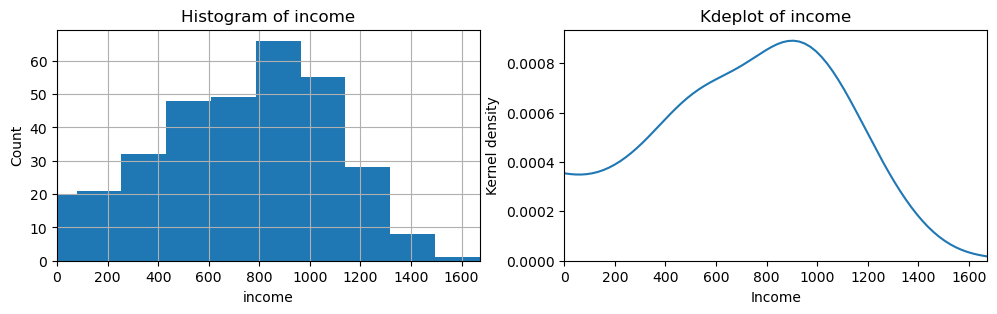

In [7]:
# 用pandas自带hist绘制收入直方图
fig = plt.figure(1,(12,3),dpi = 100)    
ax1 = plt.subplot(121)
plt.sca(ax1)
df0['income'].hist(ax = ax1,bins = 20)
plt.ylabel('Count')
plt.xlabel('income')
plt.xlim(0,df0['income'].quantile(1))
plt.title('Histogram of income')

# 用seaborn绘制kdeplot核密度分布
ax2 = plt.subplot(122)
plt.sca(ax2)
sns.kdeplot(df0['income'],ax = ax2,label = 'Income')
plt.ylabel('Kernel density')
plt.xlabel('Income')
plt.xlim(0,df0['income'].quantile(1))
plt.title('Kdeplot of income')
plt.show()
fig.savefig('./images/income.png')


车手们的收入基本满足正态分布，但是有一些车手的收入特别高，这些车手的收入是如何得到的呢？值得进一步分析

### 问题一：去哪接客挣钱多？（地点）
在分析了出租车一天的收入后，就需要分析去哪接客挣钱多，从而得知出租车司机的接客策略。  
首先是每分钟的收入统计

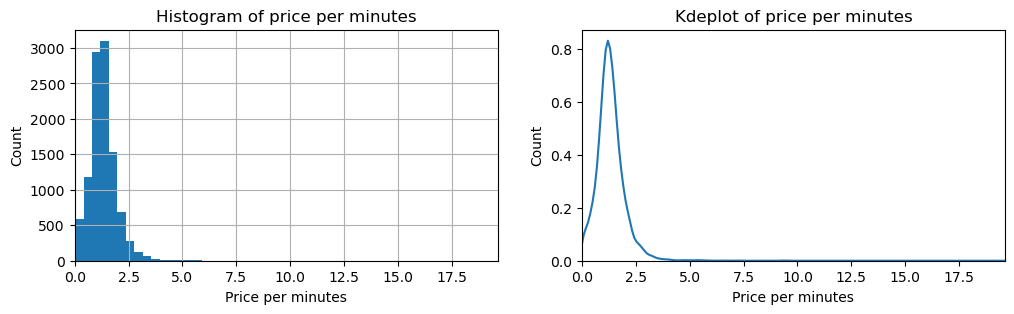

In [8]:
# 用pandas自带hist绘制直方图
fig = plt.figure(1,(12,3),dpi = 100)    
ax1 = plt.subplot(121)
plt.sca(ax1)
table5['price_per_minutes'].hist(ax = ax1,bins = 50)
plt.ylabel('Count')
plt.xlabel('Price per minutes')
plt.title('Histogram of price per minutes')
plt.xlim(0,table5['price_per_minutes'].max())

# 用seaborn绘制kdeplot核密度分布
ax2 = plt.subplot(122)
plt.sca(ax2)
sns.kdeplot(table5['price_per_minutes'],ax = ax2,label = 'Income')
plt.ylabel('Count')
plt.xlabel('Price per minutes')

plt.xlim(0,table5['price_per_minutes'].quantile(1))
plt.title('Kdeplot of price per minutes')
plt.show()
fig.savefig('./images/price-per-minutes.png')


这里可以看到，大部分出租车司机的每分钟收入都在0-2.5r左右，但是也有一部分司机的收入在5-7.5r之间，这是为什么呢？是因为这些司机的接客策略不一样吗？还是因为其他原因呢？接下来我们需要分析其与订单地点的关系。  
绘制一下热力图，看看在出租车订单起点处平均价格的空间分布

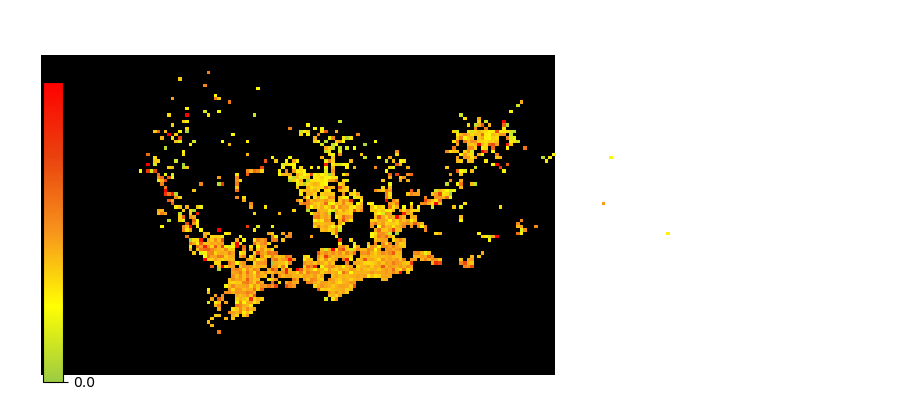

In [10]:
# 栅格数据，读取shapefile文件
import geopandas
shp = r'shapefile/grid/grid.shp'
grid = geopandas.GeoDataFrame.from_file(shp,encoding = 'gbk')

# 计算每个格子的平均收入
data = table5[['Lng','Lat','price_per_minutes']].copy()

# 经纬度小数点保留三位小数
import math
# 划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

# 定义栅格大小(单位m)
accuracy = 500;

# 计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);
data['LONCOL'] = ((data['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
data['LATCOL'] = ((data['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')

data = data.groupby(['LONCOL','LATCOL'])['price_per_minutes'].mean().reset_index()

# 将集计的结果与栅格的geopandas执行merge操作
gridtoplot = pd.merge(grid,data,on = ['LONCOL','LATCOL'])
gridtoplot.head(5)

import plot_map
# 绘制地理分布图
fig = plt.figure(1,(10,10),dpi = 100)  
ax = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))
bounds = [113.7, 22.42, 114.3, 22.8]
#绘制地图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

# 设置colormap的数据
import matplotlib
vmax = gridtoplot['price_per_minutes'].quantile(0.99)
# 设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = matplotlib.colors.Normalize(vmin=0,vmax=vmax)

# 设定colormap的颜色
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)

# 将gridtoplot这个geodataframe进行绘制
# 用gridtoplot.plot，设定里面的参数是column = 'count'，以count这一列来绘制。参数cmap = cmap设定它的颜色
gridtoplot.plot(ax = ax,column = 'price_per_minutes',cmap = cmap,vmax = vmax,vmin = 0)

# 不显示坐标轴
plt.axis('off')    
# 然后要把镜头调整回到深圳地图那，不然镜头就在imshow处
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)
# 绘制colorbar
plt.imshow([[0,vmax]], cmap=cmap)
# 设定colorbar的大小和位置
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)
plt.show()
fig.savefig('./images/heatmap-taxi-price.png')

从上面的热力图可以看出，出租车司机的收入与订单地点有关，深圳中南部一片黄。但是这里的热力图并不能很好的反映出来，因为这里的热力图是根据订单地点的经纬度进行的统计，而不是根据地点进行的统计，所以这里需要对数据进行处理，将经纬度转换为地点，然后再进行统计。这便是后续工作——

### 问题二：什么时候接客订单多？什么时候接客单笔订单价格高？
在分析了出租车司机的接客策略后，就需要分析什么时候接客订单多？什么时候接客单笔订单价格高？
这里采用折线图进行分析，看看在出租车订单起点处平均价格的空间分布和时间分布

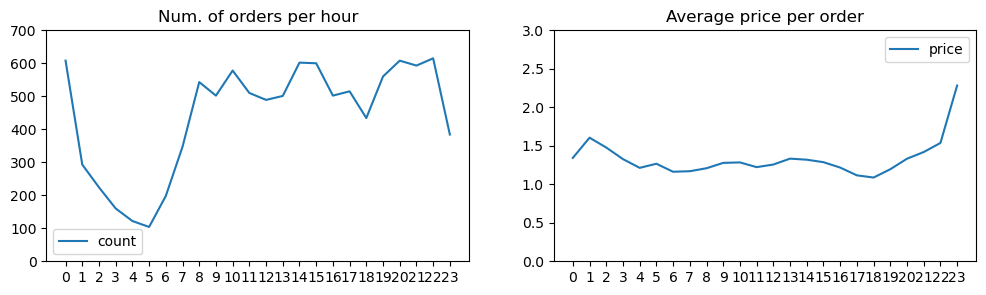

In [11]:
table5['Shour'] = pd.to_datetime(table5['Stime']).apply(lambda r:r.hour)
# 每小时订单数
df1 = table5.groupby(['Shour'])['VehicleNum'].count().reset_index()
# 每小时平均订单价格
df2 = table5.groupby(['Shour'])['price_per_minutes'].mean().reset_index()
fig = plt.figure(1,(12,3),dpi = 100)    

#创建一个子图
ax1 = plt.subplot(121)
plt.sca(ax1)

#绘制折线图
plt.plot(df1['Shour'],df1['VehicleNum'],label = 'count')
plt.legend()
plt.title('Num. of orders per hour')
plt.xticks(range(24),df1['Shour'])
plt.ylim(0,700)
#创建另一个子图
ax2 = plt.subplot(122)
plt.sca(ax2)

#绘制折线图
plt.plot(df1['Shour'],df2['price_per_minutes'],label = 'price')
plt.legend()
plt.title('Average price per order')
plt.xticks(range(24),df1['Shour'])
plt.ylim(0,3)
plt.show()
fig.savefig('./images/nums-of-orders-per-hour.png')

这里可以发现：基本上出租车司机以白天接单居多，但是明显可以发现晚上的单价偏高

### 问题三：收入最高的车手与收入中等的车手，挣钱方式有什么不一样吗
这里我们认为，收入处于前20%的出租车手为高收入，而收入排名40%-60%为中等收入车手，  
观察高收入中收入群体每天的订单数量，与订单每分钟收入分布情况

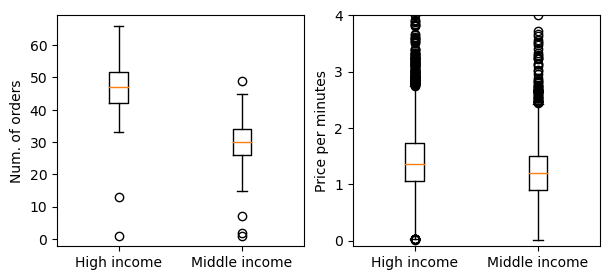

In [12]:
highincome = df0[df0['income']>df0['income'].quantile(0.8)]['VehicleNum']
midincome = df0[(df0['income']>df0['income'].quantile(0.4))&(df0['income']<df0['income'].quantile(0.6))]['VehicleNum']

# 提取两组车手的订单
highincome_order = pd.merge(table5,highincome,on = 'VehicleNum')
midincome_order = pd.merge(table5,midincome,on = 'VehicleNum')

# 观察高收入中收入群体每天的订单数量，与订单每分钟收入分布情况
# 高收入中收入群体每天的订单数量
fig = plt.figure(1,(7,3),dpi = 100)    
ax = plt.subplot(121)
plt.sca(ax)
plt.boxplot([highincome_order.groupby('VehicleNum')['orderid'].count(),
midincome_order.groupby('VehicleNum')['orderid'].count()])
plt.xticks([1,2],['High income','Middle income'])
plt.ylabel('Num. of orders')

#订单每分钟收入分布情况
ax = plt.subplot(122)
plt.sca(ax)
plt.boxplot([highincome_order['price_per_minutes'],
midincome_order['price_per_minutes']])
plt.xticks([1,2],['High income','Middle income'])
plt.ylim(-0.1,4)
plt.ylabel('Price per minutes')
plt.show()
fig.savefig('./images/Price-per-minutes.png')

### 问题1-3结论:

由上面的统计图可以分析得到：
图一可以看到，高收入车手每日接单数量说比中收入车手多的，也就得到了第一个结论：高收入主要靠努力  
图二可看到，高收入车手的订单的每分钟平均收入也要稍微比中收入车手高，这也就是说，高收入车手靠的不仅仅是努力，还有技巧  

那么，高收入车手接的单为什么会稍微贵一点呢？猜想可能的原因有两种，猜想如下：  
1.高收入车手每天非常努力，根据深圳出租价格特点，可能半夜也出来接单，这样就比较贵  
2.高收入车手存在拒载现象，或者只在特定区域接单，避免接到便宜的单，单价较贵  

下面为进一步的差距分析——

### 问题四：高收入车手比中收入车手更努力吗
这里需要计算高收入群体和中收入群体开车总路程，空驶总路程，载客总路程

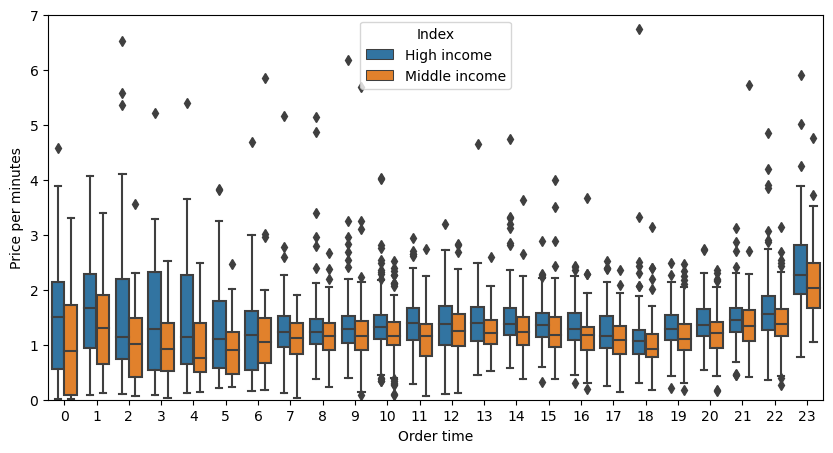

In [21]:
high_hour = highincome_order[['Stime','price_per_minutes']].copy()
high_hour['Shour'] = pd.to_datetime(highincome_order['Stime']).apply(lambda r:r.hour)
high_hour['Index'] = 'High income'
mid_hour =  midincome_order[['Stime','price_per_minutes']].copy()
mid_hour['Shour'] = pd.to_datetime(midincome_order['Stime']).apply(lambda r:r.hour)
mid_hour['Index'] = 'Middle income'
hourdata = pd.concat([high_hour,mid_hour])

# 绘图
fig = plt.figure(1,(10,5),dpi = 100)    
ax = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="Shour", y="price_per_minutes",hue="Index", data=hourdata,ax = ax)
plt.ylabel('Price per minutes')
plt.xlabel('Order time')
plt.ylim(0,7)
plt.show()
fig.savefig('./images/price-per-minutes-per-hour.png')


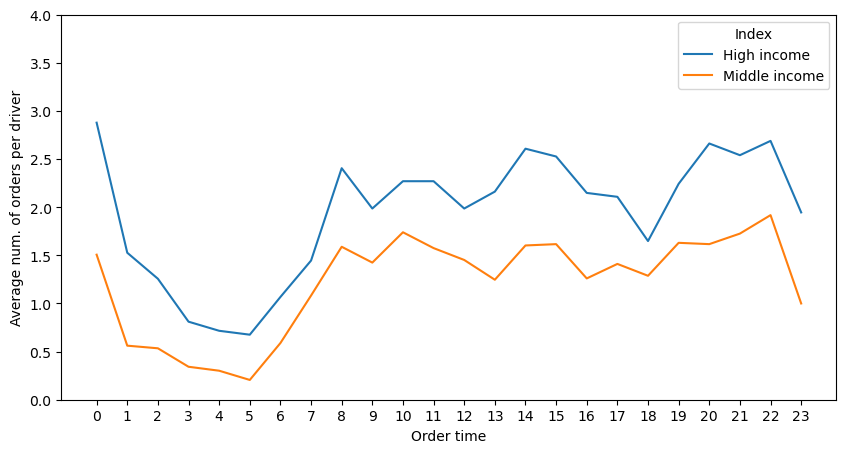

In [22]:
# 统计高收入者和低收入者每小时平均的订单数量
high_hour =  (highincome_order.groupby(pd.to_datetime(highincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(highincome)).reset_index().rename(columns = {'price':'avg_count'})
high_hour['Index'] = 'High income'


mid_hour =  (midincome_order.groupby(pd.to_datetime(midincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(midincome)).reset_index().rename(columns = {'price':'avg_count'})
mid_hour['Index'] = 'Middle income'

# 绘图
fig = plt.figure(1,(10,5),dpi = 100)    
ax = plt.subplot(111)
plt.sca(ax)
sns.lineplot(x="Stime", y="avg_count",hue="Index", data=pd.concat([high_hour,mid_hour]),ax = ax)
plt.ylabel('Average num. of orders per driver')
plt.xlabel('Order time')
plt.ylim(0,4)
plt.xticks(range(24),range(24))
plt.show()
fig.savefig('./images/avg-count.png')


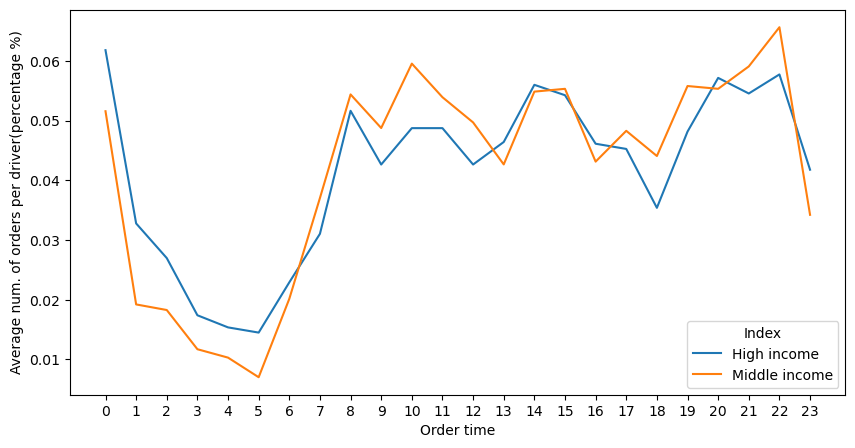

In [23]:
#统计高收入者和低收入者每小时平均的订单数量
high_hour =  (highincome_order.groupby(pd.to_datetime(highincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(highincome)).reset_index().rename(columns = {'price':'avg_count'})
high_hour['Index'] = 'High income'
high_hour['avg_count'] = high_hour['avg_count']/high_hour['avg_count'].sum()
mid_hour =  (midincome_order.groupby(pd.to_datetime(midincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(midincome)).reset_index().rename(columns = {'price':'avg_count'})
mid_hour['Index'] = 'Middle income'
mid_hour['avg_count'] = mid_hour['avg_count']/mid_hour['avg_count'].sum()
#绘图
fig = plt.figure(1,(10,5),dpi = 100)    
ax = plt.subplot(111)
plt.sca(ax)
sns.lineplot(x="Stime", y="avg_count",hue="Index", data=pd.concat([high_hour,mid_hour]),ax = ax)
plt.ylabel('Average num. of orders per driver(percentage %)')
plt.xlabel('Order time')
plt.xticks(range(24),range(24))
plt.show()
fig.savefig('./images/avg-count-percentage.png')


由上面的三个图，我们可以得到结论：高收入车手比中收入者更倾向于在夜间活动，这可能是因为夜间赚钱多的原因。这也印证了我们在问题二中的推断；他们也貌似工作更努力一点

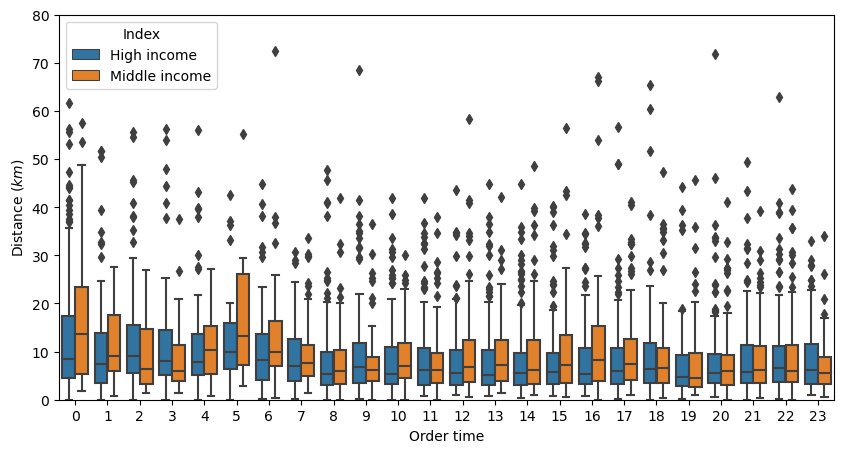

In [15]:
# 统计高收入者和低收入者每小时订单的出行距离
high_hour =  highincome_order[['Stime','distance']].copy()
high_hour['Shour'] = pd.to_datetime(highincome_order['Stime']).apply(lambda r:r.hour)
high_hour['Index'] = 'High income'
mid_hour =  midincome_order[['Stime','distance']].copy()
mid_hour['Shour'] = pd.to_datetime(midincome_order['Stime']).apply(lambda r:r.hour)
mid_hour['Index'] = 'Middle income'
hourdata = pd.concat([high_hour,mid_hour])
hourdata['distance'] = hourdata['distance']/1000

#绘图
fig = plt.figure(1,(10,5),dpi = 100)    
ax = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="Shour", y="distance",hue="Index", data=hourdata,ax = ax)
plt.ylabel('Distance $(km)$')
plt.ylim(0,80)
plt.xlabel('Order time')
plt.show()
fig.savefig('./images/distance-status.png')

这里我们埋下了一个疑惑的种子，貌似从里程上看，高收入司机并没有比低收入跑的更多，那么高收入司机是如何赚到更多的钱的呢？这里我们需要分析一下高收入司机的接单地点，这是因为他们开车技术更好吗？

### 问题五：高收入车手比中收入车手开车技术更好吗
这里我们观察一下每小时高收入群体和中等收入群体的订单收入情况  
将高收入和中等收入的订单打上标签，合并一起，后面可以用seaborn绘制分组的boxplot

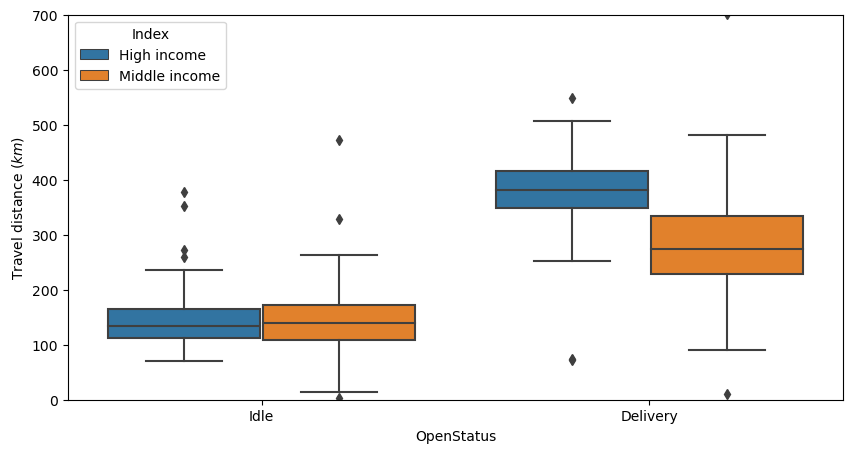

In [27]:
# 计算每辆车的空驶距离和载客距离，报错KeyError: 'VehicleNum'
disagg = datapro2.groupby(['VehicleNum','OpenStatus'])['distance'].sum().reset_index()

# 整理数据到一个DataFrame中
highagg = pd.merge(highincome,disagg, on = 'VehicleNum')
highagg['Index'] = 'High income'
highagg['distance'] = highagg['distance']/1000
midagg = pd.merge(midincome,disagg, on = 'VehicleNum')
midagg['Index'] = 'Middle income'
midagg['distance'] = midagg['distance']/1000

# 绘图
fig = plt.figure(1,(10,5),dpi = 100)    
ax = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="OpenStatus", y="distance",hue="Index", data=pd.concat([highagg,midagg]),ax = ax)
plt.ylabel('Travel distance $(km)$')
plt.ylim(0,700)
plt.xticks([0,1],['Idle','Delivery'])
plt.show()
fig.savefig('./images/travel-distance.png')


很有意思的结论出来了：

1.高收入车手一天中空载的行驶距离与中等收入车手处于同一个水平，但载客距离则明显高一个水平，也就是说，高收入车手虽然开车的总距离长，但是多的距离都在载客距离上！    
2.高收入车手的空驶距离和载客距离的方差都比中等收入车手小，说明他们更能够控制自己每天的行驶距离，也就是，他们开车更稳、技术更好~

### 问题六：高收入车手与中收入车手接客地点差在哪？


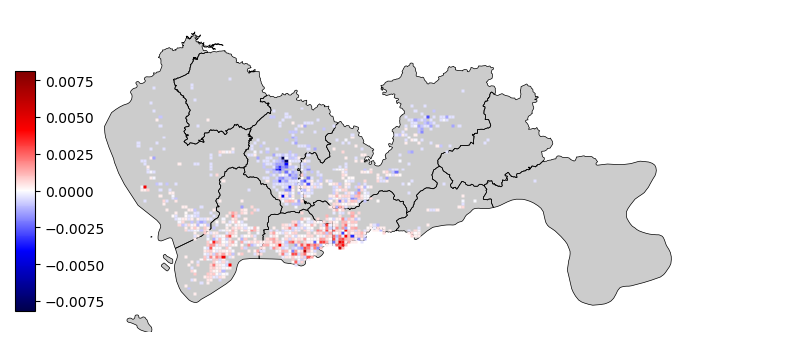

In [16]:
data_list = []
# 高收入 计算每个格子的平均收入
data = highincome_order[['Lng','Lat','orderid']].copy()

# 删格化+集计
data['LONCOL'] = ((data['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
data['LATCOL'] = ((data['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
data = data.groupby(['LONCOL','LATCOL'])['orderid'].count().reset_index()
data['orderid'] = data['orderid']/data['orderid'].sum()
data = data.rename(columns = {'orderid':'highincome_rate'})
data_list.append(data)

# 中收入：计算每个格子的平均收入
data = midincome_order[['Lng','Lat','orderid']].copy()

# 删格化+集计
data['LONCOL'] = ((data['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
data['LATCOL'] = ((data['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
data = data.groupby(['LONCOL','LATCOL'])['orderid'].count().reset_index()
data['orderid'] = data['orderid']/data['orderid'].sum()
data = data.rename(columns = {'orderid':'midincome_rate'})

data_list.append(data)

# 将高收入和中收入的分布比例merge
data = pd.merge(data_list[0],data_list[1],on = ['LONCOL','LATCOL'],how = 'outer').fillna(0)

# 计算每个格子接客数量比例差距
data['gap'] = data['highincome_rate']-data['midincome_rate']

# 栅格数据 读取shapefile文件
shp = r'shapefile/grid/grid.shp'
grid = geopandas.GeoDataFrame.from_file(shp,encoding = 'gbk')

# 将集计的结果与栅格的geopandas执行merge操作
gridtoplot = pd.merge(grid,data,on = ['LONCOL','LATCOL'])
gridtoplot.head(5)

# 绘制GIS图
fig = plt.figure(1,(10,8),dpi = 100)    
ax = plt.subplot(111)
plt.sca(ax)
bounds = [113.6,22.4,114.8,22.9]

# plot_map绘制地图底图
# 绘制行政区划
shp = r'shapefile/sz.shp'
xzqh = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.2),linewidths=0.5)

# 设置colormap的数据
vmax = max(gridtoplot['gap'].max(),-gridtoplot['gap'].min())
# 设定colormap的颜色
cmapname = 'seismic'
cmap = matplotlib.cm.get_cmap(cmapname)

# 将gridtoplot这个geodataframe进行绘制
gridtoplot.plot(ax = ax,column = 'gap',edgecolor = (0,0,0,0),cmap = cmap,vmax = vmax,vmin = -vmax)
# 不显示坐标轴
plt.axis('off')    

# 绘制colorbar
plt.imshow([[-vmax,vmax]], cmap=cmap)
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()
fig.savefig('./images/gap-gis.png')


问题六的结论：  
如图，红色区域表示高收入更倾向于接客的地点，蓝色区域表示中等收入群体更倾向于接客的地点  
市中心一片红，郊区一片蓝，高收入车手更喜欢在市中心接客，尤其在罗湖福田中心区，
且更多出现在一些枢纽区域（保安机场，罗湖火车站，皇岗口岸，深圳湾口岸等等）  

### 问题七：高收入与中收入车手OD的差别
这里，我们将高收入车手和中收入车手的OD数据进行对比，看看他们的OD分布有什么不同。

   SLONCOL  SLATCOL  ELONCOL  ELATCOL  highcount  midcount  count
0        2       20       12        5        1.0       0.0    1.0
1        3       10        3       10        5.0       0.0    5.0
2        3       10        7        7        1.0       0.0    1.0
3        3       10        8        2        2.0       0.0    2.0
4        3       10        8        4        1.0       0.0    1.0
33.0
绘制OD
OD绘制时间： 2.394556999206543


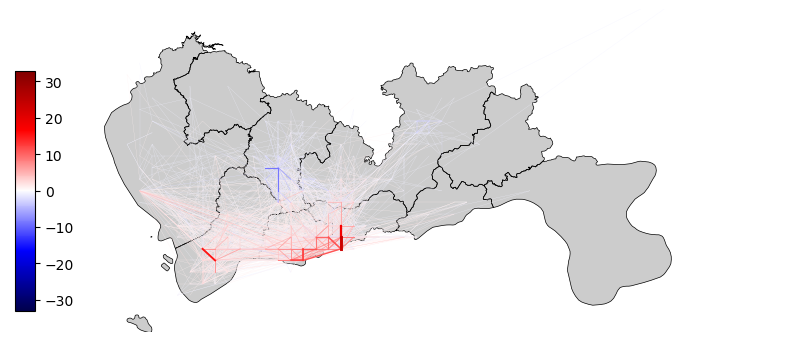

In [24]:
# 栅格化代码
# 划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748
latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

# 定义栅格大小(单位m)
accuracy = 2000;
# 计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

# 高收入OD统计
highincome_order['SLONCOL'] = ((highincome_order['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
highincome_order['SLATCOL'] = ((highincome_order['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
highincome_order['ELONCOL'] = ((highincome_order['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
highincome_order['ELATCOL'] = ((highincome_order['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
hod = highincome_order[['SLONCOL','SLATCOL','ELONCOL','ELATCOL']].copy()
hod['highcount'] = 1
hod = hod.groupby(['SLONCOL','SLATCOL','ELONCOL','ELATCOL'])['highcount'].count().reset_index()

# 中收入OD统计
midincome_order['SLONCOL'] = ((midincome_order['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
midincome_order['SLATCOL'] = ((midincome_order['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
midincome_order['ELONCOL'] = ((midincome_order['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
midincome_order['ELATCOL'] = ((midincome_order['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
mod = midincome_order[['SLONCOL','SLATCOL','ELONCOL','ELATCOL']].copy()
mod['midcount'] = 1
mod = mod.groupby(['SLONCOL','SLATCOL','ELONCOL','ELATCOL'])['midcount'].count().reset_index()

# 高收入中收入OD合计
allod = pd.merge(hod,mod,on = ['SLONCOL','SLATCOL','ELONCOL','ELATCOL'],how = 'outer').fillna(0)
allod['count'] = allod['highcount'] - allod['midcount']
print(allod.head(5))

#计算起点栅格的中心点经纬度
allod['SHBLON'] = allod['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
allod['SHBLAT'] = allod['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)
#计算终点栅格的中心点经纬度
allod['EHBLON'] = allod['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
allod['EHBLAT'] = allod['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

#按从小到大排序，并且计算alpha值
vmax = max(allod['count'].max(),-allod['count'].min())
allod['alpha'] = abs(allod['count'])/vmax
allod = allod.sort_values(by = 'alpha')
print(vmax)

fig = plt.figure(1,(10,8),dpi = 100)    
ax = plt.subplot(111)
plt.sca(ax)
bounds = [113.6,22.4,114.8,22.9]

# 绘制底图的农村网太慢了，暂时不画底图，直接绘制行政区划
shp = r'shapefile/sz.shp'
xzqh = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.2),linewidths=0.5)

# 设定colormap
import matplotlib as mpl
vmax = max(allod['count'].max(),-allod['count'].min())
norm = mpl.colors.Normalize(vmin=-vmax,vmax=vmax)
cmapname = 'seismic'
cmap = matplotlib.cm.get_cmap(cmapname)

# 绘制OD
print('绘制OD')
import time
starttime = time.time()
for i in range(len(allod)):
    # 设定plt.plot里面的参数alpha和color和linewidth
    color_i=cmap(norm(allod['count'].iloc[i]))
    linewidth_i=3*max(0.05,allod['alpha'].iloc[i])
    plt.plot([allod['SHBLON'].iloc[i],allod['EHBLON'].iloc[i]],
             [allod['SHBLAT'].iloc[i],allod['EHBLAT'].iloc[i]],
             color=color_i,linewidth=linewidth_i)
endtime = time.time()
print('OD绘制时间：',endtime-starttime)
    
plt.axis('off')
plt.imshow([[-vmax,vmax]], cmap=cmap)
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)
plt.show()
fig.savefig('./images/od-gap.png')

d:\Anaconda3\envs\paddle_env\lib\site-packages\pandas\core\dtypes\cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


绘制OD2
OD2绘制时间： 0.15504050254821777


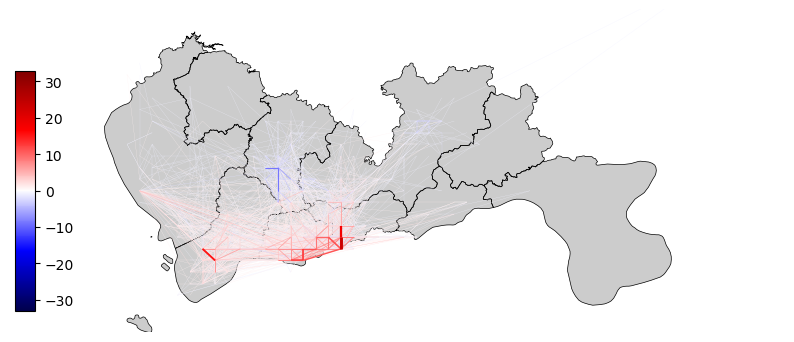

In [25]:
# 更快速度的办法-用geopandas来画图
from shapely.geometry import LineString
#生成GeoDataFrame
odgpd = geopandas.GeoDataFrame()
odgpd['alpha'] = allod['alpha']
odgpd['count'] = allod['count']
odgpd['geometry'] = allod.apply(lambda r:LineString([[r['SHBLON'],r['SHBLAT']],[r['EHBLON'],r['EHBLAT']]]),axis = 1)
#将最小的线粗细定义为0.05
odgpd.loc[odgpd['alpha']<0.05,'alpha'] = 0.05

fig = plt.figure(1,(10,8),dpi = 100)    
ax = plt.subplot(111)
plt.sca(ax)
bounds = [113.6,22.4,114.8,22.9]

shp = r'shapefile/sz.shp'
xzqh = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.2),linewidths=0.5)

vmax = max(allod['count'].max(),-allod['count'].min())
norm = mpl.colors.Normalize(vmin=-vmax,vmax=vmax)
cmapname = 'seismic'
cmap = matplotlib.cm.get_cmap(cmapname)

print('绘制OD2')
import time
starttime = time.time()
odgpd.plot(ax = ax,column = 'count',vmax = vmax,vmin = -vmax,cmap = cmap,linewidth = 3*odgpd['alpha'])
endtime = time.time()
print('OD2绘制时间：',endtime-starttime)
    
plt.axis('off')    
plt.imshow([[-vmax,vmax]], cmap=cmap)
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)
plt.show()
fig.savefig('./images/od-gap-2.png')

### 问题4-7：高收入车手策略总结
从上面的分析来看，高收入群体确实存在高收入的秘诀，总结一下，那就是：  

1.努力，高收入出租车手需要比别人更努力，每天跑更多的路程，接更多的单  
2.选择性接单（拒载），由于起步价的原因，高收入需要比别人接更多的短距离出行订单（高收入车手接的订单平均出行距离比中收入车手短！）  
3.工作时间，高收入车手在夜间、凌晨的订单比例比中收入车手更高，半夜开车挣钱多！  
4.开车技术，在控制自己的空载行驶路程与别人持平的同时，增加自己载客的行驶路程，从而多赚钱    5.接客地点，尽量在市中心，单价会更高   
5.接客地点，尽量在市中心，单价会更高  

那么据此，我们在下面提出问题八——  


### 问题八：进一步分析：空载时候的候车时间有没有差别？
经过查阅，我猜测一个出租车手的技术体现(收入差距)不在于载客状态，而在于空载状态，由于上面的数据体现出来的，为什么高收入出租车手每天的订单数量多，而每天的空载里程却跟中等收入的选手差距不大？理论上来说，订单多理应路程长才对。

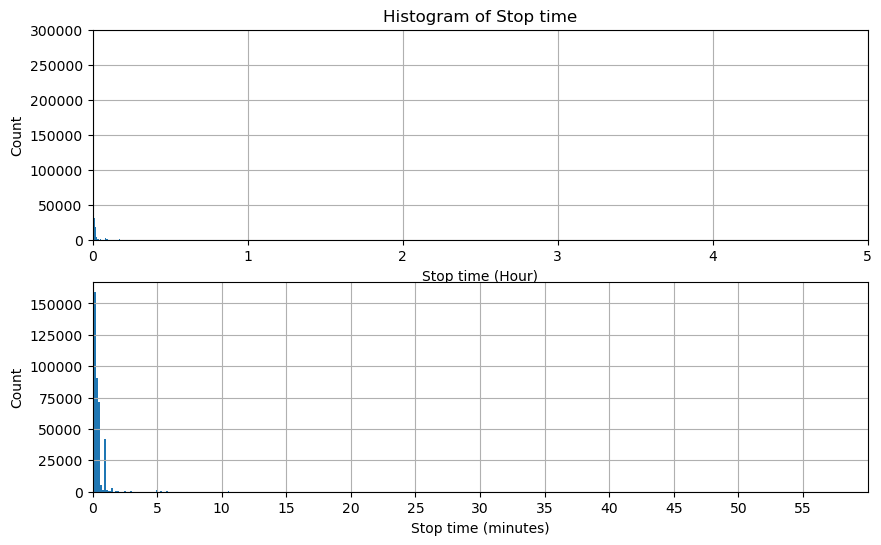

In [18]:
data = datapro # 读取数据
intervaldata = data[data['distance']==0]['interval']/3600

# 用pandas自带hist绘制直方图
fig = plt.figure(1,(10,6),dpi = 100)    
ax1 = plt.subplot(211)
plt.sca(ax1)
intervaldata.hist(ax = ax1,bins = 400)
plt.ylabel('Count')
plt.xlabel('Stop time (Hour)')
plt.xticks(range(24),range(24))
plt.title('Histogram of Stop time')
plt.xlim(0,5)

ax1 = plt.subplot(212)
plt.sca(ax1)
(intervaldata[intervaldata<1]*60).hist(ax = ax1,bins = 400)
plt.ylabel('Count')
plt.xlabel('Stop time (minutes)')
plt.xticks(range(0,60,5),range(0,60,5))
plt.xlim(0,60)
plt.show()
fig.savefig('./images/stop-time.png')


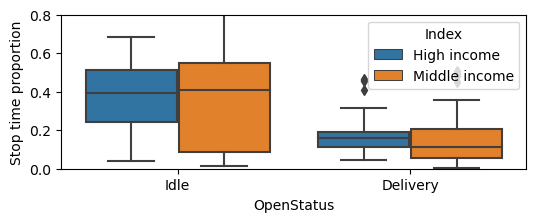

In [19]:
# 停车时间绝大部分都是非常短的，剔除30分钟以上的停车摸鱼时间
# 删掉30分钟以上的停车
data = data[-((data['distance']==0)&(data['interval']>=1800))]

# 高收入数据和中收入数据打上标签后合并在一起处理
highincome_data = pd.merge(data,highincome,on = 'VehicleNum')
highincome_data['Index'] = 'High income'
highincome_data['isstop'] = highincome_data['distance']==0
midincome_data = pd.merge(data,midincome,on = 'VehicleNum')
midincome_data['Index'] = 'Middle income'
midincome_data['isstop'] = midincome_data['distance']==0

# 计算停车时间占运营时间的比例
tmp1 = pd.concat([midincome_data,highincome_data]).groupby(['isstop','VehicleNum','OpenStatus','Index'])['interval'].sum().reset_index()
tmp1 = pd.merge(tmp1[tmp1['isstop']],tmp1[-tmp1['isstop']],on = ['VehicleNum','OpenStatus','Index'])
tmp1['rate'] = tmp1['interval_x']/(tmp1['interval_x']+tmp1['interval_y'])

# 绘图
fig = plt.figure(1,(6,2),dpi = 100)    
ax = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="OpenStatus", y="rate",hue="Index", data=tmp1,hue_order=['High income','Middle income']
,ax = ax)
plt.ylabel('Stop time proportion')
plt.xticks([0,1],['Idle','Delivery'])
plt.ylim(0,0.8)
plt.show()
fig.savefig('./images/stop-time-proportion.png')


令人惊讶的结论，和我的猜测相反：  
数据显示的与先前的猜测正好相反，高收入在空载时和载客时的停车时间比例都要比中等收入的高，原因居然是——  
测试结果为：空载时多停车，减少油耗；载客时反而要多停车，增加候时费……  
这样也就解决了我们在之前的疑惑。